<a href="https://colab.research.google.com/github/amrit-thapa-2044/R_with_google_colab/blob/main/permafrost_mapping_using_python_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from platform import python_version
print(python_version())

3.7.13


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Importing the dataset
dataset = pd.read_csv('/content/drive/MyDrive/data_for_permafrost_mapping_using_python/icimod_training_csvfile.csv')
X = dataset.iloc[:,[1,2]].values
y = dataset.iloc[:,0].values

In [6]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [7]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


In [8]:
# Fitting Logistic Regression to the Training Set

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [9]:
# Printing the coefficients and the intercept of the Logistic Regression model
print(classifier.coef_, classifier.intercept_)

[[-0.36248706 -2.56248991]] [0.28449767]


In [10]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [11]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


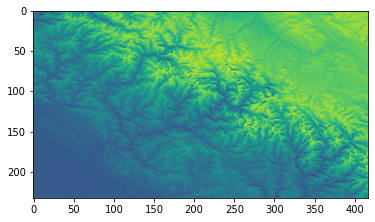

In [12]:
from PIL import Image
im_b02 = Image.open('/content/drive/MyDrive/data_for_permafrost_mapping_using_python/Solar_radiation_grid_01_May_31_Oct_kwhr.tif')
imarray_b02 = np.array(im_b02)
plt.imshow(imarray_b02)

b_b02 = imarray_b02.ravel()

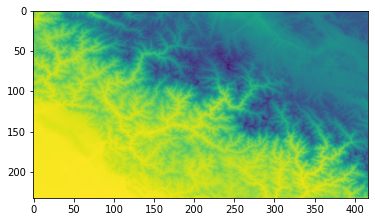

In [13]:
im_b03 = Image.open('/content/drive/MyDrive/data_for_permafrost_mapping_using_python/Worldclim_maat.tif')
imarray_b03 = np.array(im_b03)
plt.imshow(imarray_b03)

b_b03 = imarray_b03.ravel()

In [14]:
#Stacking the two columns for MAAT and PISR
stack_grids = np.column_stack((b_b02,b_b03))
sc_stack_grids = sc_X.fit_transform(stack_grids)

In [15]:
#Predicting the probability of permafrost (as 0 and 1) based on MAAT and PISR grids
y_pred_0_1 = classifier.predict(sc_stack_grids)

In [16]:
# Predicting the probability of permafrost (as values between 0 and 1) based on MAAT and PISR grids
y_pred_probability = classifier.predict_proba(sc_stack_grids)
probability_no = y_pred_probability[:,0]
probability_yes = y_pred_probability[:,1] 


In [17]:
# Reshaping the probability values
probability_no_reshape = np.reshape(probability_no,(233,417))
probability_yes_reshape = np.reshape(probability_yes,(233,417)) 

In [18]:
# Convert to PIL Image and save
Image.fromarray(probability_no_reshape).save('/content/drive/MyDrive/data_for_permafrost_mapping_using_python/Probability_permafrost_absence.tif')  
Image.fromarray(probability_yes_reshape).save('/content/drive/MyDrive/data_for_permafrost_mapping_using_python/Probability_permafrost_presence.tif')                                              


In [20]:
# Georeferencing the grid for permafrost probability
from osgeo import gdal
import matplotlib.pyplot as plt

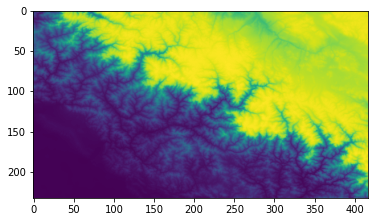

In [21]:
# Importing georeferenced and non-georeferenced data set

ds = gdal.Open("/content/drive/MyDrive/data_for_permafrost_mapping_using_python/Solar_radiation_grid_01_May_31_Oct_kwhr.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

im_b02 = Image.open('/content/drive/MyDrive/data_for_permafrost_mapping_using_python/Probability_permafrost_presence.tif')
array = np.array(im_b02)

plt.figure()
plt.imshow(array)

In [22]:
# Georeferencing and exporting the dataset
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("/content/drive/MyDrive/data_for_permafrost_mapping_using_python/Probability_permafrost_presence_georeferenced.tif", xsize = array.shape[1],
                      ysize = array.shape[0], bands = 1, 
                      eType = gdal.GDT_Float32)
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(array)
outband.SetNoDataValue(np.nan)
outband.FlushCache()

# Closing data set and bands

outband = None
outds = None